In [55]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [56]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [57]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [58]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [59]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [60]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [61]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [62]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [63]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(most_recent_date)


('2017-08-23',)


In [64]:
from datetime import datetime

def parse_date(date_string):
    try:
        return datetime.strptime(date_string, '%Y-%m-%d')
    except ValueError:
        print(f"Error: The date '{date_string}' is not in the expected format (YYYY-MM-DD).")
        return None

# An example of a correct date string
date_good = "2021-01-01"
print(parse_date(date_good))

# An example of an incorrect date string that will trigger the ValueError
date_bad = "2"
print(parse_date(date_bad))

2021-01-01 00:00:00
Error: The date '2' is not in the expected format (YYYY-MM-DD).
None


<Figure size 1000x600 with 0 Axes>

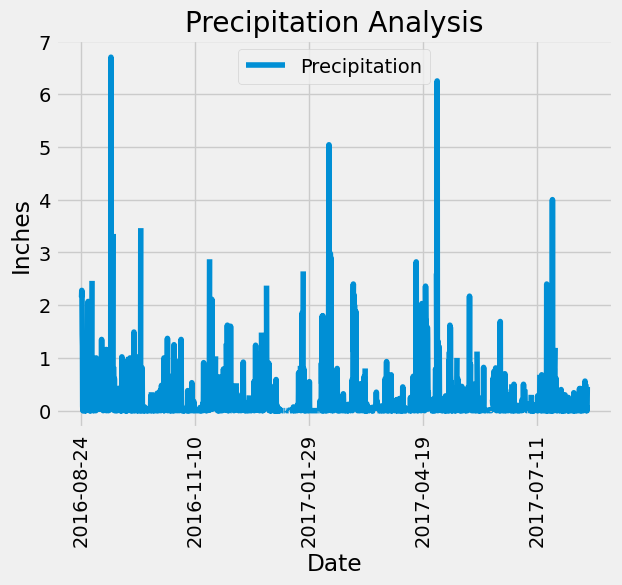

In [73]:

# Design a query to retrieve the last 12 months of precipitation data 
# and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
start_date = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
df_query = session.query(measurement.date, measurement.prcp).filter(measurement.date >= start_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation = pd.DataFrame(df_query, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation = precipitation.sort_values(['Date'], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
precipitation.plot(x='Date', y='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches') 
plt.legend()
plt.xticks(rotation=90)
plt.title('Precipitation Analysis')
plt.show()

In [75]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation['Precipitation'].describe()

summary_statistics


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [76]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station.distinct())).scalar()
print(f"Total number of stations in the dataset: {total_stations}")


Total number of stations in the dataset: 9


In [77]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    measurement.station, 
    func.count(measurement.station)
).group_by(measurement.station
).order_by(func.count(measurement.station).desc()
).all()

print("Most active stations and their counts:")
for station, count in most_active_stations:
    print(f"Station {station} has {count} rows.")

Most active stations and their counts:
Station USC00519281 has 2772 rows.
Station USC00519397 has 2724 rows.
Station USC00513117 has 2709 rows.
Station USC00519523 has 2669 rows.
Station USC00516128 has 2612 rows.
Station USC00514830 has 2202 rows.
Station USC00511918 has 1979 rows.
Station USC00517948 has 1372 rows.
Station USC00518838 has 511 rows.


In [78]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]

temperature_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(measurement.station == most_active_station_id
).all()

min_temp, max_temp, avg_temp = temperature_stats[0]

print(f"Most active station ID: {most_active_station_id}")
print(f"Lowest temperature recorded: {min_temp}")
print(f"Highest temperature recorded: {max_temp}")
print(f"Average temperature recorded: {round(avg_temp, 2)}")

Most active station ID: USC00519281
Lowest temperature recorded: 54.0
Highest temperature recorded: 85.0
Average temperature recorded: 71.66


<Figure size 1000x600 with 0 Axes>

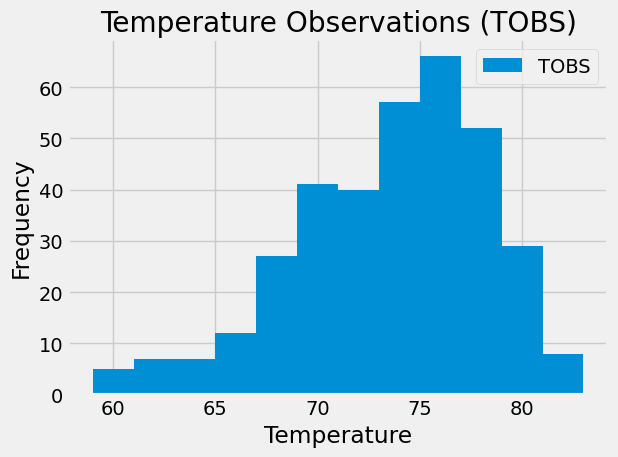

In [79]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= start_date).all()

temperatures = [temp[0] for temp in results]

df_temperatures = pd.DataFrame(temperatures, columns=['Temperature'])

plt.figure(figsize=(10, 6))
df_temperatures.plot.hist(bins=12, title="Temperature Observations (TOBS)")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["TOBS"])
plt.tight_layout()
plt.show()

# Close Session

In [71]:
# Close Session
session.close()